# Recommender systems

Content based on the following lectures https://www.youtube.com/watch?v=1JRrCEgiyHM&t=767s

On offline sellers we are faced with scarce commodity. This is related with the stock costs. 
This means that products with local popularity don't have presence in the most stores. This is the long tail curve.
![logtail_curve](images/long_tail_curve.png)

# Types of recommendations
- editorial and hand curated (biase by the people that do the recommendentaion based on his knowledge)
- simple aggregates i.e top 10 sellers, recent upload
- tailored approach: based on item, based on customers info or both


# key problems
 ## Gathering ratings
 - explicit ratings i.e much more easy but dificult to scale
 
 - implicint rations i.e learn rating based on user actions based on clicks. The downside is to learn low rating because people wont click on that. 
 
## Extrapolate unknown ratings from the known ones
- sparse matrix U because most people do not rate most items
- cold start problem i.e. when a new product or customer is add into the loop

## Evaluating extrapolation methods i.e. How should we measure the success/performance of recommendation methods
- content-based 
- collaborative
- latent factor based

------------------------------------------------------------------------------------------------------

# Content based recommendation engines

The main idea of this approach is to recommend items to customer x, based on privious items rated by x. 
An example of this is to select movies based on genre or main actor. 

# Plan of action
- extract features for each item
- match those with the user - build user profile
- then recommend the items that match the user profile

## Pros:
 - No need data on others users
 - Able to recommend users with unique tates
 - no first rater problem
 - explainations on recommended items
 
 ## Cons:
 - need to generate accurate features for the item i.e items, movies
 - overspecialization due to people multiple interests
 - How to build a profile for a new user? most recommendation engines use an average profile to start. Personal take on this: Companies on this example can buy data from other companies like facebook.

# Example
based on this dataset https://www.kaggle.com/zygmunt/goodbooks-10k

In [17]:
# packages 
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [2]:
# check available documents in the folder

In [3]:
available_files = os.listdir('data/goodbooks')
print(available_files)

# book_tags = tags count for each book
# book.csv info + ratings count
# books marked as to read by the users
# match tagid with tag name
# ratings by user and by book


['book_tags.csv', 'books.csv', 'to_read.csv', 'tags.csv', 'ratings.csv', 'sample_book.xml']


In [4]:
pd.read_csv('data/goodbooks/books.csv', encoding = "ISO-8859-1")

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPrÃ©",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,7130616,7130616,7392860,19,441019455,9.780441e+12,Ilona Andrews,2010.0,Bayou Moon,...,17204,18856,1180,105,575,3538,7860,6778,https://images.gr-assets.com/books/1307445460m...,https://images.gr-assets.com/books/1307445460s...
9996,9997,208324,208324,1084709,19,067973371X,9.780680e+12,Robert A. Caro,1990.0,Means of Ascent,...,12582,12952,395,303,551,1737,3389,6972,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
9997,9998,77431,77431,2393986,60,039330762X,9.780393e+12,Patrick O'Brian,1977.0,The Mauritius Command,...,9421,10733,374,11,111,1191,4240,5180,https://images.gr-assets.com/books/1455373531m...,https://images.gr-assets.com/books/1455373531s...
9998,9999,8565083,8565083,13433613,7,61711527,9.780062e+12,Peggy Orenstein,2011.0,Cinderella Ate My Daughter: Dispatches from th...,...,11279,11994,1988,275,1002,3765,4577,2375,https://images.gr-assets.com/books/1279214118m...,https://images.gr-assets.com/books/1279214118s...


In [5]:
ratings_df = pd.read_csv('data/goodbooks/ratings.csv')

In [6]:
# number of duplicated ratings
ratings_df.duplicated().sum()

1644

In [7]:
clean_ratings_df = ratings_df.drop_duplicates()

In [8]:
print(' len before duplicate cleaning: ', len(ratings_df))
print('len after remove duplicates: ', len(clean_ratings_df))
if len(ratings_df) -  len(clean_ratings_df) == 1644:
    print('Duplicates removal OK!!!!!!!!!')
else:
    print(' Duplicates removal NOK. Dataset version might have change. plz check')    

 len before duplicate cleaning:  981756
len after remove duplicates:  980112
Duplicates removal OK!!!!!!!!!


## rating by user and bookid

In [9]:
clean_ratings_df.groupby(by=['book_id', 'user_id']).count()['rating'].value_counts()
# this means that we have some some user that rated twice a particular book 
# probably we are going to replace this repeted rating by some value. My first idea now is to replace
# by the avg of the ratings

1    978845
2       632
3         1
Name: rating, dtype: int64

## ratings per user

In [10]:
# count of ratign per user
count_ratings_user =  clean_ratings_df.groupby(by = 'user_id').count()['rating'].value_counts()
total_users = count_ratings_user.sum()
print('number of users: ', total_users)

number of users:  53424


In [11]:
count_ratings_user

2      8302
3      5438
4      3976
5      3219
6      2464
       ... 
197       2
164       2
150       2
200       2
158       1
Name: rating, Length: 199, dtype: int64

In [12]:
# total number of ratings
print(len(clean_ratings_df))
min_ratings = 3
print("users with less than 3 ratings",count_ratings_user[count_ratings_user.index < min_ratings].sum() )
print("% ",
      round((count_ratings_user[count_ratings_user.index < min_ratings].sum() / len(clean_ratings_df)) * 100,2),
     " of the user have less than 3 ratings")

980112
users with less than 3 ratings 8337
%  0.85  of the user have less than 3 ratings


## Subset data

In order to speed the calculation and due to training purposes I am going to subset the number of clients.

In [13]:
client_fraction = 0.2 

# to sensure reproducibility
random.seed(1)
users_set = set(clean_ratings_df['user_id'].unique())  # use set due to random.sample requirement


In [14]:
users_subset = random.sample(users_set, int(total_users * client_fraction))
total_subset_users = len(users_subset)
print('total subset users: ', total_subset_users)

total subset users:  10684


In [15]:
# now we need to filter our ratings based on the selected users

In [16]:
subset_ratings_df = clean_ratings_df.loc[clean_ratings_df.user_id.isin(users_subset),:]
print('new subset rating length: ', len(subset_ratings_df))

new subset rating length:  197783


# EDA - Exploratory Data Analysis

## Ratings distribution

In [24]:
# set matplotlib theme
plt.style.use('ggplot')


Text(0.5, 1.0, 'Count of rating of all subset users')

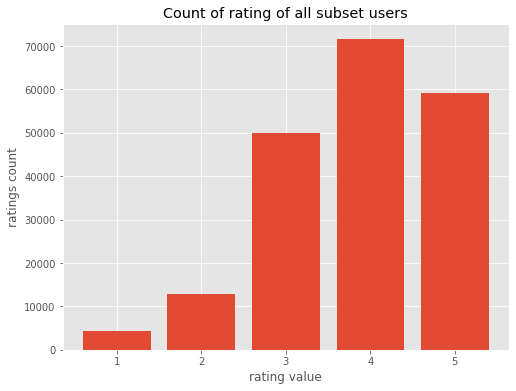

In [72]:
unique_ratings = sorted(subset_ratings_df.rating.unique())
plt.figure(figsize=(8,6))
counts = list(subset_ratings_df.rating.value_counts().sort_index().values)
_ = plt.bar(x =unique_ratings, height = counts)
plt.xticks( [1,2,3,4,5])
plt.xlabel('rating value')
plt.ylabel('ratings count')
plt.title('Count of rating of all subset users')

[4228, 12947, 49888, 71560, 59160]

In [42]:
bins

array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ])

In [55]:
sorted(subset_ratings_df.rating.unique())

[1, 2, 3, 4, 5]